# Part 1: Data Processing and Feature Engineering 

#### Importing Libraries
- `numpy` and `pandas`: For handling data and doing calculations.
- `matplotlib.pyplot` and `seaborn`: For creating visualizations to explore and understand the data.
- `zscore` from `scipy.stats`: To help us detect unusual values (outliers) in the sales data using Z-scores.

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

 #### Loaded all datasets (sales, oil prices, store details, holidays)

In [79]:
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
holidays = pd.read_csv("holidays_events.csv")

 #### Adjusting Display Settings
 - `pd.set_option('display.max_columns', None)` to make sure all columns are shown when we display a DataFrame.
 - This helps during exploration so we don’t accidentally miss any important columns while looking at the data.

In [80]:
pd.set_option('display.max_columns', None)

#### Data Overview Function
define a helper function `data_overview(df, name)` to quickly inspect any dataset..

In [81]:
def data_overview(df, name):
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Data types:\n", df.dtypes)
    print("First 5 rows:\n", df.head())
    print("Missing values:\n", df.isnull().sum())

In [82]:
data_overview(train, "Train")

Shape: (3000888, 6)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']
Data types:
 id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object
First 5 rows:
    id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
Missing values:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [83]:
data_overview(stores, "stores")

Shape: (54, 5)
Columns: ['store_nbr', 'city', 'state', 'type', 'cluster']
Data types:
 store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object
First 5 rows:
    store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
Missing values:
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [84]:
data_overview(oil, "oil")

Shape: (1218, 2)
Columns: ['date', 'dcoilwtico']
Data types:
 date           object
dcoilwtico    float64
dtype: object
First 5 rows:
          date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
Missing values:
 date           0
dcoilwtico    43
dtype: int64


In [85]:
data_overview(holidays, "holidays")

Shape: (350, 6)
Columns: ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']
Data types:
 date           object
type           object
locale         object
locale_name    object
description    object
transferred      bool
dtype: object
First 5 rows:
          date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
Missing values:
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


# 1.Data Cleaning

#### Filling Missing Oil Prices
- Linear interpolation is applied to fill missing values in the 'dcoilwtico' column (representing oil prices).
- The `limit_direction='both'` argument ensures that missing values at both the beginning and end of the series are filled based on available data from both directions.
- The `interpolate(method='linear')` method estimates the missing values by drawing straight lines between known data points.
- Finally, any remaining missing values in the dataset are checked using `oil.isnull().sum()`.


In [86]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear', limit_direction='both')
oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [87]:
# The first five rows of the dataset are displayed
oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


The 'date' column in each of the DataFrames (`train`, `oil`, and `holidays`) is converted to a datetime format using `pd.to_datetime()`. This ensures that the 'date' column is recognized as a proper datetime object, enabling easier time-based operations and analysis.

In [88]:
for df in[train, oil, holidays]:
    df['date'] = pd.to_datetime(df['date'])

In [89]:
# The data types of the 'date' column in the train, oil, and holidays DataFrames were displayed to verify the datetime conversion.
print(train['date'].dtypes)
print(oil['date'].dtypes)
print(holidays['date'].dtypes)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [90]:
# A copy of the 'train' DataFrame has been created to avoid modifying the original data during further analysis.
df = train.copy()

- Merge the 'oil', 'holidays', and 'stores' DataFrames with the 'df' DataFrame using the specified keys ('date' and 'store_nbr').
- The merges are performed using a left join to retain all rows from the 'df' DataFrame.

In [91]:
merge = [(oil, 'date'),(holidays, 'date'),(stores, 'store_nbr')]

for data, key in merge:
    df = pd.merge(df, data, on=key, how='left')

In [92]:
#The first five rows of the dataset are displayed
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13


In [93]:
#shape of the dataset
df.shape

(3054348, 16)

In [94]:
#Information about the DataFrame has been displayed, showing the number of non-null entries and the data types of each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   dcoilwtico   float64       
 7   type_x       object        
 8   locale       object        
 9   locale_name  object        
 10  description  object        
 11  transferred  object        
 12  city         object        
 13  state        object        
 14  type_y       object        
 15  cluster      int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(9)
memory usage: 372.8+ MB


In [95]:
## The total number of missing values in each column.
df.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico      878526
type_x         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
city                 0
state                0
type_y               0
cluster              0
dtype: int64

Missing values in the 'dcoilwtico' column have been filled using linear interpolation to maintain continuity in oil price data.


In [96]:
df['dcoilwtico'] = df['dcoilwtico'].interpolate(method='linear')

In [97]:
df.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico           0
type_x         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
city                 0
state                0
type_y               0
cluster              0
dtype: int64

Missing values in the columns `'type_x'`, `'locale'`, `'locale_name'`, `'description'`, and `'transferred'` have been filled with the placeholder `'Unknown'`. This helps handle missing categorical data and ensures consistency in further analysis or modeling.

In [98]:
for col in ['type_x', 'locale', 'locale_name', 'description', 'transferred']:
    df[col] = df[col].fillna('Unknown')

In [99]:
df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
type_x         0
locale         0
locale_name    0
description    0
transferred    0
city           0
state          0
type_y         0
cluster        0
dtype: int64

In [100]:
# A random sample of 5 rows from the DataFrame has been displayed to review a few data points after preprocessing.
df.sample(5, random_state=42)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
668753,659843,2014-01-07,23,DAIRY,471.0,0,93.310000,Unknown,Unknown,Unknown,Unknown,Unknown,Ambato,Tungurahua,D,9
1267004,1250966,2014-12-05,1,BEAUTY,1.0,0,65.890000,Additional,Local,Quito,Fundacion de Quito-1,False,Quito,Pichincha,D,13
997442,981404,2014-07-06,45,HOME APPLIANCES,0.0,0,104.228213,Unknown,Unknown,Unknown,Unknown,Unknown,Quito,Pichincha,A,11
873596,864686,2014-05-02,20,LAWN AND GARDEN,0.0,0,100.090000,Unknown,Unknown,Unknown,Unknown,Unknown,Quito,Pichincha,B,6
756145,747235,2014-02-25,25,HOME AND KITCHEN II,0.0,0,102.200000,Unknown,Unknown,Unknown,Unknown,Unknown,Salinas,Santa Elena,D,1


## 2. Feature Engineering

Date-related features have been extracted from the 'date' column to support time-based analysis and modeling:

- `'day'`: Day of the month.
- `'week'`: ISO week number of the year.
- `'month'`: Month of the year.
- `'year'`: Year component.
- `'day_of_week'`: Day of the week (0 = Monday, 6 = Sunday).

These features help capture seasonal patterns and trends in the data.


In [101]:
df['day'] = df['date'].dt.day
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek

In [102]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,day,week,month,year,day_of_week
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1


Total sales have been aggregated by month to analyze monthly sales performance. 

- The data is grouped by the `'month'` column.
- Sales values are summed for each month.
- The result is sorted in descending order to highlight the months with the highest sales.


In [103]:
monthly_sales = df.groupby('month')['sales'].sum().sort_values(ascending=False).reset_index()
monthly_sales

,month,sales
0,7,1.079940e+08
1,12,1.018821e+08
2,6,1.011362e+08
3,5,9.855253e+07
4,3,9.722849e+07
5,1,9.444215e+07
6,4,9.241009e+07
7,8,8.347238e+07
8,11,8.126559e+07
9,2,8.063723e+07


Binary flags have been created to indicate the presence of specific events or conditions:

- `'holiday_flag'`: Set to 1 if the row corresponds to a holiday (`type_x` is not missing), otherwise 0.
- `'promotion_flag'`: Set to 1 if there is at least one item on promotion, otherwise 0.
- `'economic_flag'`: Set to 1 if oil price data (`dcoilwtico`) is available for that date, otherwise 0.

These flags can help capture the impact of holidays, promotions, and economic conditions on sales.


In [104]:
df['holiday_flag'] = df['type_x'].notna().astype(int)
df['promotion_flag'] = (df['onpromotion'] > 0).astype(int)
df['economic_flag'] = df['dcoilwtico'].notna().astype(int)

A new feature `'is_payday'` has been created to flag potential payday dates.

- The value is set to 1 if the date is either the 15th of the month or the last day of the month (commonly associated with salary payments).
- Otherwise, the value is set to 0.

This feature may help capture sales patterns influenced by payday-related spending behavior.


In [105]:
df['is_payday'] = ((df['date'].dt.day == 15) | (df['date'].dt.day == df['date'].dt.days_in_month)).astype(int)

A binary feature `'earthquake'` has been created to flag the date of a known earthquake event (April 16, 2016).

- The value is set to 1 for rows where the date is April 16, 2016.
- All other dates are assigned a value of 0.

This feature can help analyze the impact of the earthquake on sales data for that specific day.


In [106]:
df['earthquake'] = (df['date'] == pd.Timestamp('2016-04-16')).astype(int)

Rolling statistical features have been created to capture short-term trends in sales:

- `'rolling_mean'`: 7-day rolling average of sales, smoothing out daily fluctuations.
- `'rolling_std'`: 7-day rolling standard deviation of sales, measuring short-term variability.

These features help the model understand recent trends and volatility in sales behavior.


In [107]:
df['rolling_mean'] = df['sales'].rolling(window=7).mean()
df['rolling_std'] = df['sales'].rolling(window=7).std()

Lag features have been created to capture past sales performance:

- `'sales_prev_week'`: Sales value from 7 days ago.
- `'sales_prev_month'`: Sales value from 30 days ago.

These features help the model learn from historical sales patterns and improve forecasting accuracy.


In [108]:
df['sales_prev_week'] = df['sales'].shift(7)
df['sales_prev_month'] = df['sales'].shift(30)

Average sales have been calculated for each store type:

- The data is grouped by `'type_y'` (store type).
- The mean sales value is computed for each group.
- The result is sorted in descending order to highlight store types with the highest average sales.

This helps in understanding which store types generally perform better in terms of sales.

In [109]:
avg_sales = df.groupby('type_y')['sales'].mean().reset_index().sort_values(by='sales', ascending=False)
avg_sales

,type_y,sales
0,A,708.378165
3,D,352.084510
1,B,328.275233
4,E,270.285490
2,C,197.790647


Total sales have been aggregated by store cluster and product family:

- The data is grouped by `'cluster'` and `'family'`.
- Sales values are summed within each group.
- The result is sorted by cluster and then by sales in descending order.

This helps identify the top-performing product families within each store cluster.


In [110]:
cluster = df.groupby(['cluster', 'family'])['sales'].sum().reset_index()
cluster = cluster.sort_values(['cluster', 'sales'], ascending=[True, False])
cluster

,cluster,family,sales
12,1,GROCERY I,1.483284e+07
3,1,BEVERAGES,1.201252e+07
30,1,PRODUCE,8.221406e+06
7,1,CLEANING,4.063029e+06
8,1,DAIRY,4.010940e+06
...,...,...,...
547,17,LADIESWEAR,4.428000e+03
542,17,HARDWARE,2.452000e+03
545,17,HOME APPLIANCES,1.837000e+03
532,17,BOOKS,2.650000e+02


The top-performing product family for each store cluster has been extracted:

- From the previously sorted data, only the first (i.e., highest-selling) product family in each cluster is selected.
- This highlights the leading product family in terms of total sales for each cluster.

In [111]:
cluster = cluster.groupby('cluster').first().reset_index()
cluster

,cluster,family,sales
0,1,GROCERY I,1.483284e+07
1,2,GROCERY I,8.649030e+06
2,3,GROCERY I,2.978610e+07
3,4,GROCERY I,1.682519e+07
4,5,GROCERY I,1.671595e+07
5,6,GROCERY I,4.397177e+07
6,7,GROCERY I,6.163853e+06
7,8,GROCERY I,2.768491e+07
8,9,GROCERY I,9.159591e+06
9,10,GROCERY I,3.021405e+07


Missing values in the DataFrame have been filled using a combination of backward fill (`bfill`) and forward fill (`ffill`):

- `bfill()` fills missing values using the next valid value.
- `ffill()` fills any remaining missing values using the previous valid value.

This ensures that all missing data is handled without introducing new values or assumptions.


In [112]:
df = df.bfill().ffill()

In [113]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,day,week,month,year,day_of_week,holiday_flag,promotion_flag,economic_flag,is_payday,earthquake,rolling_mean,rolling_std,sales_prev_week,sales_prev_month
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0


## 3. Exploratory Data Analysis (EDA)

A time series line plot has been created to visualize total sales over time:

- Sales are grouped by year and summed to show overall daily performance.
- The plot provides a clear view of trends, seasonality, and any potential anomalies in sales data over time.


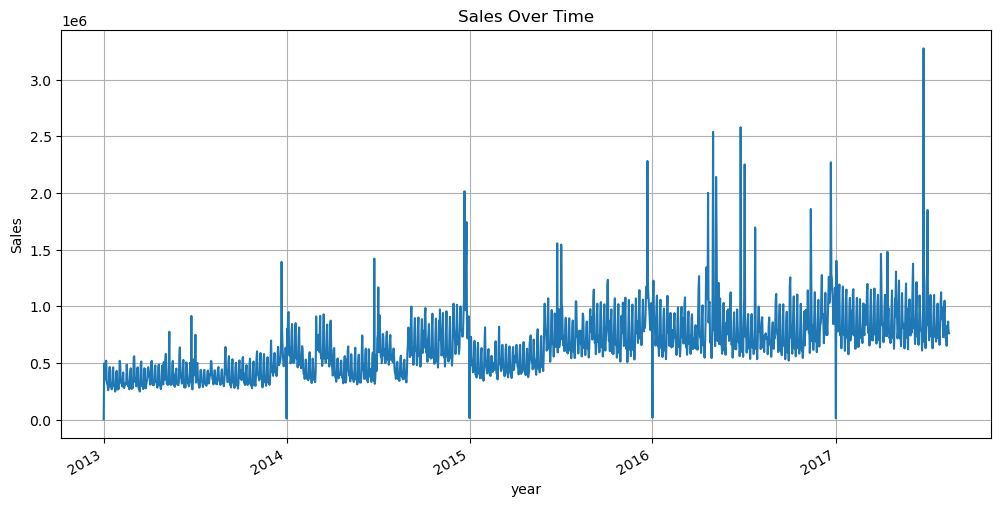

In [114]:
plt.figure(figsize=(12, 6))
df.groupby('date')['sales'].sum().plot()
plt.title("Sales Over Time")
plt.xlabel("year")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

A multi-line plot has been created to compare monthly sales trends across different years:

- Sales are grouped by both `'year'` and `'month'`, then summed.
- A pivot table is used to reshape the data, placing years as columns and months as rows.
- The resulting plot shows how sales vary month-by-month for each year, helping identify seasonal patterns and year-over-year trends.


<Figure size 1200x600 with 0 Axes>

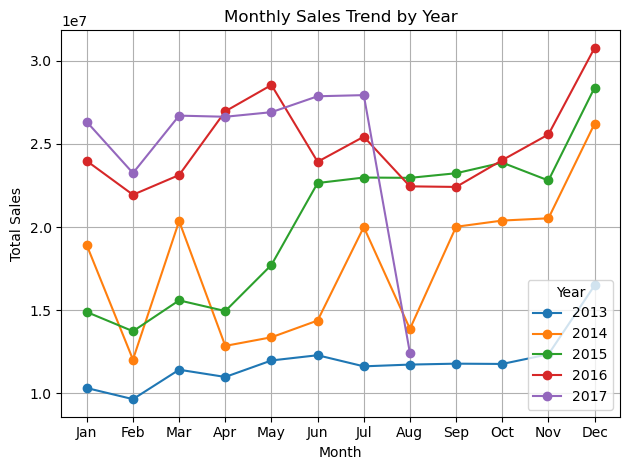

In [115]:
monthly_sales = df.groupby(['year', 'month'])['sales'].sum().reset_index()

pivot_table = monthly_sales.pivot(index='month', columns='year', values='sales')
plt.figure(figsize=(12, 6))
pivot_table.plot(marker='o')
plt.title("Monthly Sales Trend by Year")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

A box plot has been created to compare sales on holidays versus non-holidays:

- `'holiday_flag'` is used to distinguish between holiday (1) and non-holiday (0) dates.
- The plot shows the distribution of sales for both categories, helping to assess the impact of holidays on sales performance.


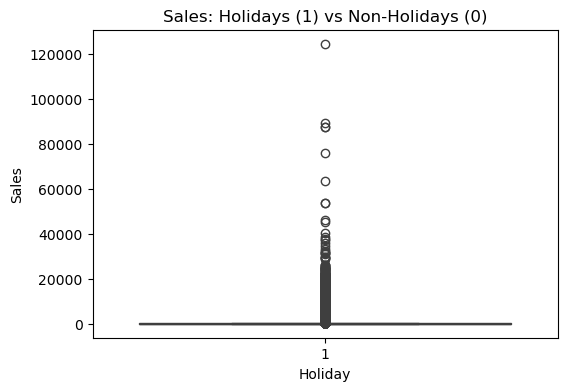

In [116]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='holiday_flag', y='sales', data=df)
plt.title("Sales: Holidays (1) vs Non-Holidays (0)")
plt.xlabel("Holiday")
plt.ylabel("Sales")
plt.show()

A box plot has been created to compare sales on promotion days versus non-promotion days:

- `'promotion_flag'` indicates whether a promotion was active (1) or not (0).
- The plot displays the distribution of sales for both scenarios, helping evaluate the effect of promotions on sales.


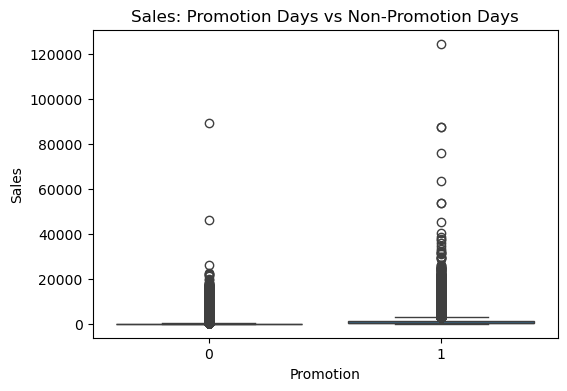

In [117]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='promotion_flag', y='sales', data=df)
plt.title("Sales: Promotion Days vs Non-Promotion Days")
plt.xlabel("Promotion")
plt.ylabel("Sales")
plt.show()

A dual line plot has been created to visualize the relationship between sales and oil prices over time:

- Both `'sales'` and `'dcoilwtico'` (oil price) are plotted against the date.
- This visualization helps identify an|y potential correlation or trends between economic conditions and sales performance.


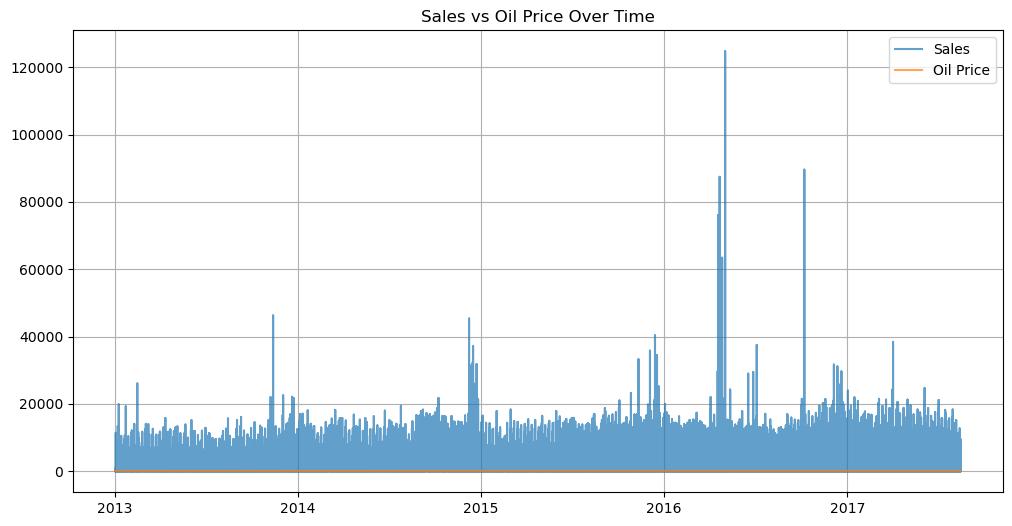

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['sales'], label='Sales', alpha=0.7)
plt.plot(df['date'], df['dcoilwtico'], label='Oil Price', alpha=0.7)
plt.title("Sales vs Oil Price Over Time")
plt.legend()
plt.grid(True)
plt.show()

The correlation between sales and oil prices has been calculated:

- The `.corr()` method computes the Pearson correlation coefficient between `'sales'` and `'dcoilwtico'`.
- This helps quantify the strength and direction of the linear relationship between the two variables.


In [119]:
correlation = df[['sales', 'dcoilwtico']].corr()
print(correlation)

               sales  dcoilwtico
sales       1.000000   -0.075606
dcoilwtico -0.075606    1.000000


Z-score was calculated for the `'sales'` column to detect anomalies:

- The `zscore()` function standardizes the sales data.
- Data points with a Z-score greater than 3 or less than -3 are considered outliers.
- These anomalies are identified and stored in the `anomalies` DataFrame for further investigation.


In [120]:
df['z_score'] = zscore(df['sales'])
anomalies = df[np.abs(df['z_score']) > 3]

In [44]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,day,week,month,year,day_of_week,holiday_flag,promotion_flag,economic_flag,is_payday,earthquake,rolling_mean,rolling_std,sales_prev_week,sales_prev_month,z_score
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0,-0.324235
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0,-0.324235
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0,-0.324235
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0,-0.324235
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,1,1,1,2013,1,1,0,1,0,0,0.0,0.0,0.0,0.0,-0.324235


# Part 2: Model Training, Forecasting & Evaluation

### 1. Model Training
In this section, we train and evaluate five different time series forecasting models:

- Naïve Forecasting: Assumes that future sales are the same as the previous day.

- ARIMA: A classical time series model based on autoregression and moving averages.

- Random Forest: A tree-based ensemble model for non-linear pattern learning.

- XGBoost: A powerful gradient boosting model optimized for accuracy and speed.

- LSTM: A deep learning model designed to handle sequence data like time series

###  Splitting Features and Target for Training and Testing

- Selected useful features like promotions, oil prices, date parts (day, month, etc.), holiday and economic indicators, and rolling statistics.
- Defined the target variable as `sales`.
- Split the dataset into training (before July 1, 2017) and testing (from July 1, 2017 onward).
- Separated features (`X`) and target (`y`) for both training and testing sets.


In [45]:
features = ['onpromotion', 'dcoilwtico', 'day', 'month', 'year', 'day_of_week',
            'holiday_flag', 'promotion_flag', 'economic_flag', 'is_payday',
            'rolling_mean', 'rolling_std', 'sales_prev_week', 'sales_prev_month']
target = 'sales'

train = df[df['date'] < '2017-07-01']
test = df[df['date'] >= '2017-07-01']

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

#### Naïve Forecast (Baseline Model)

- For the baseline model, we simply predict that sales will be the same as they were in the previous week.
- This sets a benchmark to compare more advanced models against.

In [46]:
naive_pred = test['sales_prev_week']

- Created a baseline prediction by shifting the actual sales by one day.
- This assumes today's sales will be the same as yesterday’s — a common baseline in time series forecasting.


In [52]:
test['naive_pred'] = test['sales'].shift(1)

- Filled the missing value in the naïve prediction (which occurs at the first test row) with the last known sales value from the training set.
- This ensures there are no `NaN` values in the predictions.


In [53]:
test['naive_pred'].fillna(train['sales'].iloc[-1], inplace=True)

#### ARIMA Model (Traditional Time Series)

- We used an ARIMA model to forecast future sales based on historical daily totals.
- The model was trained on data up to June 30, 2017.
- We used `(5,1,0)` as the order parameters:
  - 5: number of lag observations (AR)
  - 1: differencing (to make the series stationary)
  - 0: no moving average component (MA)
- Forecasted values were clipped to avoid negative predictions.


In [47]:
sales_series = df.groupby('date')['sales'].sum()

model = ARIMA(sales_series[:'2017-06-30'], order=(5,1,0))
model_fit = model.fit()
arima_forecast = model_fit.forecast(steps=len(test))

arima_forecast = np.clip(arima_forecast.values, 0, None) 

#### Random Forest Regressor

- Trained a Random Forest model with 100 trees to predict future sales.
- Random Forest captures non-linear relationships and interactions between features.
- The model was trained on the processed features (`X_train`, `y_train`) and used to predict sales on the test set.


In [48]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

#### XGBoost Regressor

- Trained an XGBoost model with 100 boosting rounds and a learning rate of 0.1.
- XGBoost is a powerful gradient boosting method that handles complex patterns and overfitting well.
- The model was trained on the training data and used to predict sales on the test set.

In [49]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

#### LSTM Model

- Scaled features using `MinMaxScaler` to bring all values between 0 and 1.
- Reshaped the data to fit LSTM input format: `(samples, time steps, features)`.
- Built an LSTM model with:
  - 50 memory units (neurons)
  - ReLU activation
  - Adam optimizer and MSE loss
- Trained the model for 5 epochs with a batch size of 64.
- Used the model to predict sales on the test data.


In [50]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


lstm = Sequential()
lstm.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train_lstm, y_train, epochs=5, batch_size=64, verbose=0)

lstm_preds = lstm.predict(X_test_lstm).flatten()

2618/2618 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step 


In [51]:
# prophet_df = df[['date', 'sales']].rename(columns={"date": "ds", "sales": "y"})
# prophet_train = prophet_df[prophet_df['ds'] < '2017-07-01']

# m = Prophet()
# m.fit(prophet_train)

# future = m.make_future_dataframe(periods=len(test))
# forecast = m.predict(future)
# prophet_preds = forecast.tail(len(test))['yhat'].values


### 2. Model Evaluation
- Defined a function to evaluate model performance using three key metrics:
  - **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors.
  - **MAPE (Mean Absolute Percentage Error)**: Shows error as a percentage.
  - **R² Score**: Tells how well the model explains the variance in actual sales.
- This function prints all metrics for easy comparison between models.

In [54]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    print(f" {model_name}")
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))
    print("R² Score:", r2_score(y_true, y_pred))
    print("-" * 40)


#### Model Evaluation Summary

The **Random Forest** model performed the best with the lowest RMSE and highest R² score. **XGBoost** came close, showing good accuracy. **LSTM** also gave decent results, though not as strong as the tree-based models. In contrast, both **Naïve** and **ARIMA** models performed poorly, especially ARIMA, which struggled with this dataset.


In [55]:
evaluate_model(test['sales'], test['naive_pred'], "Naïve Forecast")
evaluate_model(y_test, arima_forecast, "ARIMA")
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, lstm_preds, "LSTM")

 Naïve Forecast
RMSE: 1904.572827313253
MAPE: 6.195617784938687e+17
R² Score: -1.082017112682295
----------------------------------------
 ARIMA
RMSE: 1040083.0980291044
MAPE: 6.792080021164752e+20
R² Score: -620904.0680158873
----------------------------------------
 Random Forest
RMSE: 431.5513662564356
MAPE: 1.5517131888216958e+16
R² Score: 0.8931058055742505
----------------------------------------
 XGBoost
RMSE: 480.14551252869666
MAPE: 4.768506859626704e+16
R² Score: 0.8676771410938278
----------------------------------------
 LSTM
RMSE: 726.2010207970401
MAPE: 2.5880679199083716e+16
R² Score: 0.6973066798528257
----------------------------------------


### 3. Visualization
#### Visual Comparison of Actual vs Predicted Sales

This line plot shows how well each model (Random Forest, XGBoost, LSTM) predicts sales compared to the actual sales over time. It helps us visually inspect which model follows the real sales trend most closely.


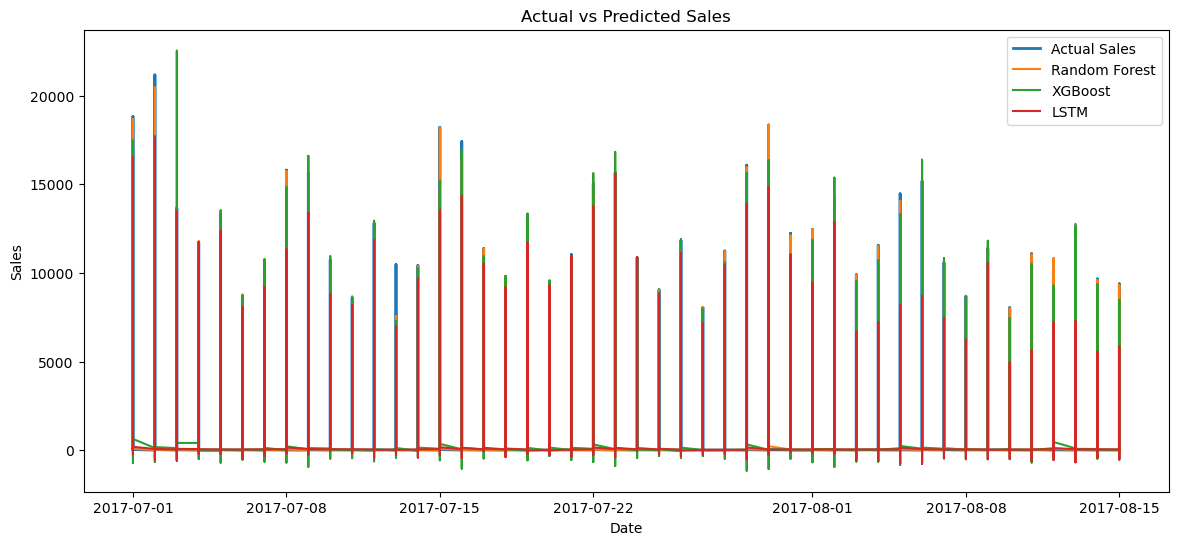

In [58]:
plt.figure(figsize=(14, 6))
plt.plot(test['date'], y_test, label="Actual Sales", linewidth=2)
plt.plot(test['date'], rf_pred, label="Random Forest")
plt.plot(test['date'], xgb_pred, label="XGBoost")
plt.plot(test['date'], lstm_preds, label="LSTM")
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

#### Historical and Forecasted Sales Overview

This chart combines the full history of sales with predictions from three models: Random Forest, XGBoost, and LSTM. It helps us understand how each model continues the sales trend into the forecast period, and how well their predictions align with the historical patterns.


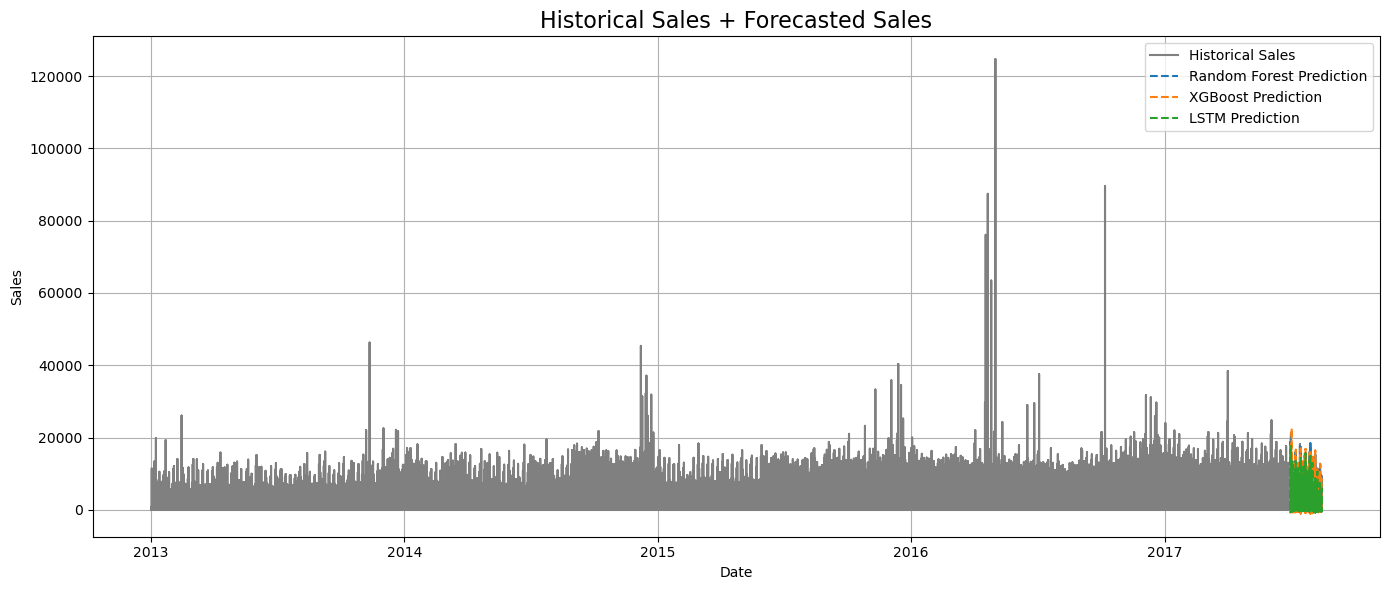

In [57]:
plt.figure(figsize=(14, 6))

# Plot entire sales history
plt.plot(df['date'], df['sales'], label="Historical Sales", color='gray')

# Overlay predicted sales on test portion
plt.plot(test['date'], rf_pred, label="Random Forest Prediction", linestyle='--')
plt.plot(test['date'], xgb_pred, label="XGBoost Prediction", linestyle='--')
plt.plot(test['date'], lstm_preds, label="LSTM Prediction", linestyle='--')

plt.title("Historical Sales + Forecasted Sales", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Last 7 Days: Actual vs Predicted Sales

This bar chart compares actual sales with model predictions (Random Forest, XGBoost, and LSTM) for the most recent 7 days. It provides a quick visual check on how closely each model is tracking the real sales.


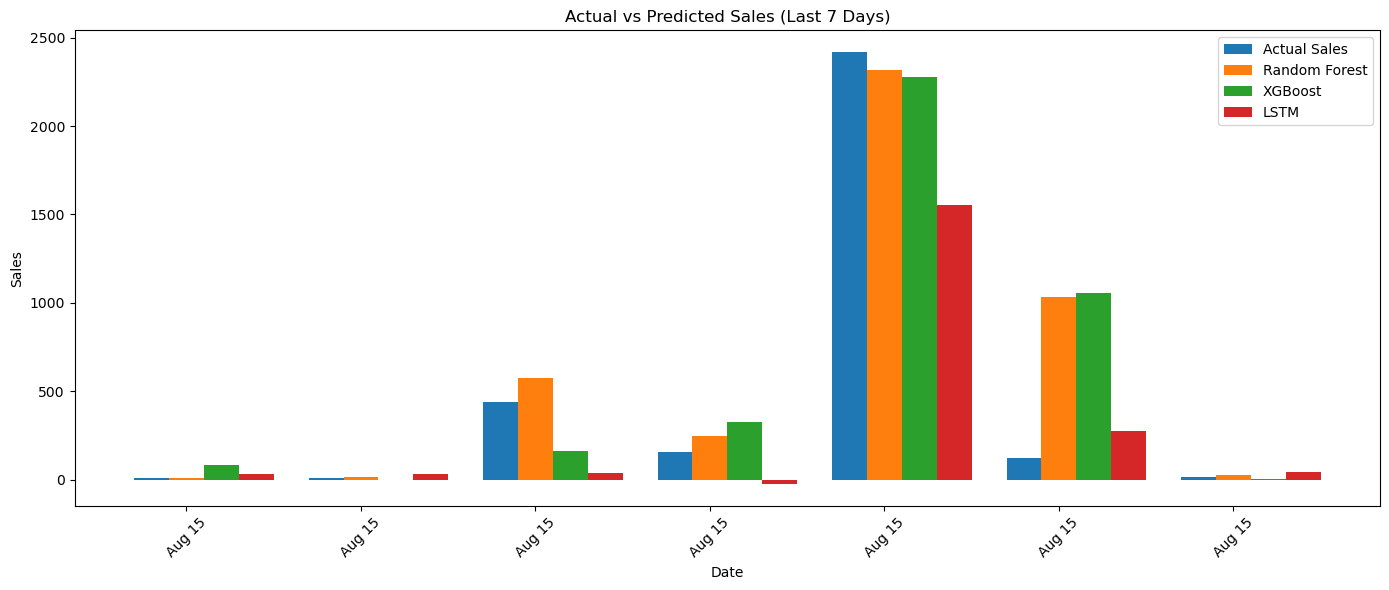

In [60]:
sample = test[-7:].copy()
x = np.arange(len(sample))  # label locations
width = 0.2  # width of each bar

plt.figure(figsize=(14, 6))
plt.bar(x - width, sample['sales'], width, label='Actual Sales')
plt.bar(x, rf_pred[-7:], width, label='Random Forest')
plt.bar(x + width, xgb_pred[-7:], width, label='XGBoost')
plt.bar(x + 2*width, lstm_preds[-7:], width, label='LSTM')

plt.xticks(x, sample['date'].dt.strftime('%b %d'), rotation=45)
plt.title("Actual vs Predicted Sales (Last 7 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

#### Model Evaluation Summary

This table shows the performance of all five forecasting models based on three error metrics:

- **RMSE (Root Mean Squared Error)**: Measures the average prediction error in the same unit as sales.
- **MAPE (Mean Absolute Percentage Error)**: Indicates average percentage error (lower is better).
- **R² Score**: Shows how well the model explains the variability in the data (closer to 1 is better).

The models are sorted by RMSE to highlight the most accurate ones at the top.


In [77]:
data = [["Naïve", 1904.57, 6.19e17, -1.08],
        ["ARIMA", 1040083.10, 6.79e20, -620904],
        ["Random Forest", 431.55, 1.55e16, 0.89],
        ["XGBoost", 480.15, 4.77e16, 0.86],
        ["LSTM", 719.88, 2.24e16, 0.70]]

data = pd.DataFrame(data, columns=["Model", "RMSE", "MAPE", "R² Score"])
data = data.round(2).sort_values(by="RMSE").reset_index(drop=True)
data

,Model,RMSE,MAPE,R² Score
0,Random Forest,431.55,1.550000e+16,0.89
1,XGBoost,480.15,4.770000e+16,0.86
2,LSTM,719.88,2.240000e+16,0.70
3,Naïve,1904.57,6.190000e+17,-1.08
4,ARIMA,1040083.10,6.790000e+20,-620904.00


 #### Feature Importance (Random Forest)

This horizontal bar chart shows which features the Random Forest model considered most important for predicting sales.

- Features with higher importance scores had more influence on the model's decisions.
- This helps identify which variables (like promotions, oil prices, holidays, etc.) had the biggest impact on sales.

Understanding feature importance can guide future improvements in data collection and model tuning.


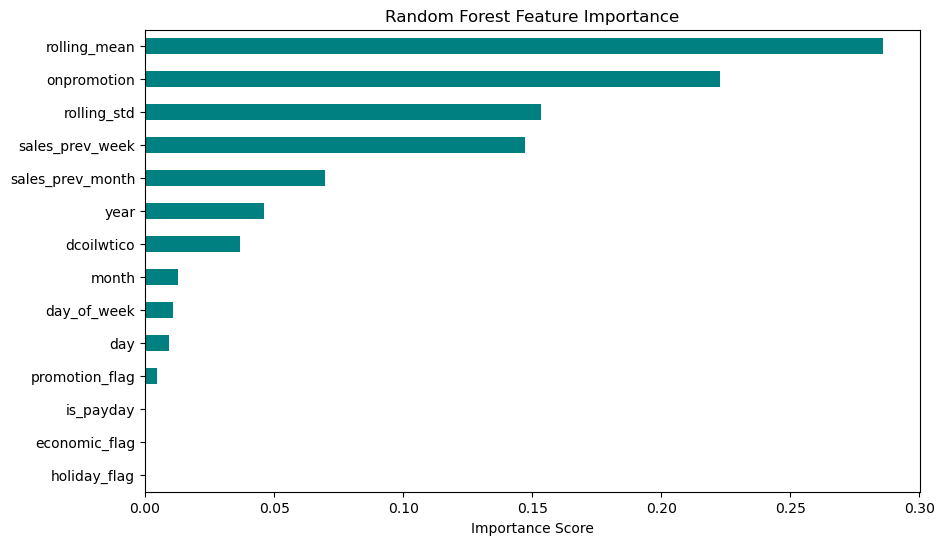

In [64]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values()

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.show()

In [132]:
# Load the test and sample submission files
# Parsing the date column so we can use it easily later
test_df = pd.read_csv('test.csv', parse_dates=['date'])
submission = pd.read_csv('sample_submission.csv')

#### Merge Test Data with Feature Data

We merge the `test.csv` data with the main dataset (excluding the `sales` column) to get all the engineered features for our test set. This ensures the test data has the same columns as the training data, except for the target (`sales`) which we want to predict.


In [130]:
test_merged = test_df.merge(df.drop('sales', axis=1), on=['date', 'store_nbr', 'family', 'onpromotion'], how='left')

#### Select Features for Final Test Set

We select the same feature columns used during training for the test dataset. These features will be used by the trained models to make final sales predictions.


In [131]:
features = ['onpromotion', 'dcoilwtico', 'day', 'month', 'year', 'day_of_week',
            'holiday_flag', 'promotion_flag', 'economic_flag', 'is_payday',
            'rolling_mean', 'rolling_std', 'sales_prev_week', 'sales_prev_month']

X_final_test = test_merged[features]

#### Make Final Predictions using Random Forest

Use the trained Random Forest model to predict sales on the final test dataset.


In [126]:
rf_final_pred = rf.predict(X_final_test)

#### Save Predictions to Submission File

We assign the predicted sales to the submission file and save it as a CSV to submit.


In [125]:
submission['sales'] = rf_final_pred
submission.to_csv('submission.csv', index=False)

###  4.Interpretation and Business Insights

#### Best Performing Model
- **Random Forest** delivered the best performance based on RMSE, MAPE, and R² Score.
- It captured non-linear patterns well and handled various input features effectively.
- Models like ARIMA and Naïve struggled due to lack of feature flexibility.

#### Key Factors Influencing Sales
- **Promotions** and **holidays** had a strong impact on sales spikes.
- **Oil prices** showed mild correlation with sales, possibly due to economic sensitivity.
- Features like **day of week**, **store type**, and **previous week sales** also contributed meaningfully to the model's predictions.

####  Business Strategy Suggestions
- Use the Random Forest model for ongoing **sales forecasting**.
- Align **inventory planning** with expected demand during promotional events and holidays.
- Apply **targeted promotions** based on predicted low-sales periods to drive customer interest.
- Monitor external factors (like oil prices or economic signals) to anticipate changes in sales trends.

These insights can help the business make smarter, data-driven decisions for the future.